**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [1]:
#Install Objax
!pip --quiet install  objax
import objax

     |████████████████████████████████| 57 kB 2.4 MB/s 


In [2]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

##**Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [ ]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

170498071/170498071 [==============================] - 15s 0us/step


The CIFAR-10 dataset contains 60000 images. The ratio of the data split is 80% training (0.8 x 60000 = 48000 images), 10% validation (0.1 x 60000 = 6000 images) and 10% test (0.1 x 60000 = 6000 images). There are 48000 training images and if in each step of gradient descent, we randomly select 32 examples, and no example appears in more than one batch, it will take 48000/32 = 1500 iterations. As going through the dataset once is one epoch, we need 30 epochs * 1500 iterations = 45000 iterations. Therefore, we need 45000 iterations.


Next we will construct a **Base Model**, which in our case is a small CNN.

In [ ]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



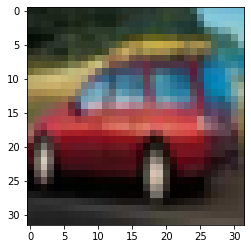

In [ ]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [ ]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

print("Filter weights:", filter_weights)
print("Conv output:", Conv2d(my_image))
print("Conv output shape:", np.shape(Conv2d(my_image)))

Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
Conv output: [[[[-0.10271908 -0.10010862 -0.09076816 ... -0.7420423  -0.73912483
    -0.7374622 ]
   [-0.12882358 -0.11180528 -0.11687267 ... -0.73105437 -0.7434611
    -0.7408506 ]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.6991137  -0.7174033
    -0.7156083 ]
   ...
   [-0.11485983 -0.10963893 -0.10963893 ... -0.11178758 -0.11439803
    -0.12222939]
   [-0.09658667 -0.09136578 -0.09136578 ... -0.1274503  -0.12483985
    -0.12483985]
   [-0.08614487 -0.08353443 -0.08614487 ... -0.16399662 -0.16138618
    -0.15355481]]

  [[ 0.10279882  0.0982345   0.08189839 ...  0.75253254  0.7320599
     0.7214626 ]
   [ 0.14844204  0.1263671   0.1275416  ...  0.77934486  0.7626404
     0.7580761 ]
   [ 0.15300636  0.12562042  0.15036322 ...  0.79253834  0.77845234
     0.775332  ]
   ...
   [ 0.20083015  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799   0.

In [ ]:
# Find dimensions of my_image and filter_weights
my_image_shape = np.shape(my_image)
filter_weights_shape = np.shape(filter_weights)
print(my_image_shape)
print(filter_weights_shape)

(1, 3, 32, 32)
(1, 1, 3, 2)


**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

In [ ]:
#Solution to the above problem

def my_conv_net(my_image, initial_filter_weights):
  "PUT YOUR CODE HERE"
  my_image_shape = np.shape(my_image)
  initial_filter_weights_shape = np.shape(initial_filter_weights)
  my_conv_output = np.zeros((my_image_shape[0], initial_filter_weights_shape[3], my_image_shape[2], my_image_shape[3])) 
  n_in, n_out, w, h = my_image_shape[1], initial_filter_weights_shape[3], my_image_shape[2], my_image_shape[3]
  for a in range(n_out):
    for b in range(w):
      for c in range(h):
        for d in range(n_in):
          my_conv_output[0][a][b][c] += my_image[0][d][b][c] * initial_filter_weights[0][0][d][a]
  return my_conv_output

print("Filter weights:", filter_weights)
my_conv_output = my_conv_net(my_image, filter_weights)
print("My Conv output:", my_conv_output)
print("My Conv output shape:", np.shape(my_conv_output))

Filter weights: [[[[ 0.7304995   0.6803058 ]
   [-1.0113425  -0.19040492]
   [-0.3848219   0.6740011 ]]]]
My Conv output: [[[[-0.10271907 -0.10010862 -0.09076816 ... -0.7420423  -0.73912489
    -0.73746228]
   [-0.12882358 -0.11180527 -0.11687266 ... -0.73105443 -0.74346107
    -0.74085063]
   [-0.13143402 -0.11577132 -0.12992492 ... -0.69911373 -0.71740329
    -0.71560836]
   ...
   [-0.11485984 -0.10963892 -0.10963892 ... -0.11178758 -0.11439803
    -0.12222938]
   [-0.09658667 -0.09136577 -0.09136577 ... -0.12745032 -0.12483985
    -0.12483985]
   [-0.08614486 -0.08353443 -0.08614486 ... -0.16399662 -0.16138616
    -0.15355483]]

  [[ 0.10279882  0.09823449  0.08189839 ...  0.75253248  0.7320599
     0.72146261]
   [ 0.14844204  0.12636711  0.1275416  ...  0.7793448   0.76264036
     0.75807607]
   [ 0.15300636  0.12562042  0.15036322 ...  0.7925384   0.7784524
     0.77533197]
   ...
   [ 0.20083013  0.1917015   0.1917015  ...  0.27218536  0.27674967
     0.29044265]
   [ 0.1688799

In [ ]:
# This will output true if my own convolution routine returns the same value as Objax's
np.allclose(my_conv_output, Conv2d(my_image))

False

The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [ ]:
#Check that .mean((2,3)) rearranges your image
my_conv_output.mean((2,3))

array([[-0.1400071 ,  0.35388903]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



In [ ]:
#PUT YOUR CODE HERE
# Take my rearranged output and feed it into a linear layer of appropriate size
Linear_Layer = objax.nn.Linear(2, 1)
Y1 = Linear_Layer(my_conv_output.mean((2,3)))

# manually implements the linear layer
Y2 = np.dot(my_conv_output.mean((2,3)), Linear_Layer.w.value) + Linear_Layer.b.value

# Print both Y1 and Y2
print("The value of the rearranged output fed into a linear layer is:", Y1[0][0])
print("The value of the manually implemented linear layer is:", Y2[0][0])

The value of the rearranged output fed into a linear layer is: 0.034715444
The value of the manually implemented linear layer is: 0.034715448


The training set is used to determine the ideal weight and bias values for parameters that reduce training error/increase training accuracy. The parameters are then updated in the training routine when the training routine calls the loss function. The output of the optimizer function is then used to determine how the parameters should be modified by using the output of the loss function. The hyperparameters are tuned using the validation set, which is often a smaller dataset than the training set. Values for hyperparameters must be chosen before the training operation is carried out. The model's parameters are not changed while utilising the validation set.

You have now completed Part 1 of the assignment. Good job!


##**Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 9.88 Validation Accuracy 10.03
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.78 Validation Accuracy 10.00
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 9.90 Validation Accuracy 10.32
Epoch 0004  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.52 Validation Accuracy 10.58
Epoch 0005  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.49 Validation Accuracy 11.25
Epoch 0006  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 10.77
Epoch 0007  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.10 Validation Accuracy 11.62
Epoch 0008  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 11.50 Validation Accuracy 12.08
Epoch 0009  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 11.84 Validation Accuracy 12.25
Epoch 0010  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 12.33 Validatio

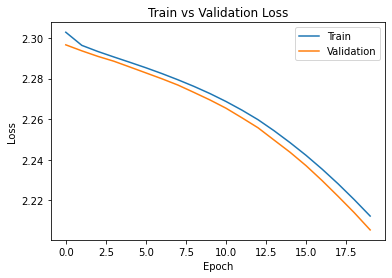

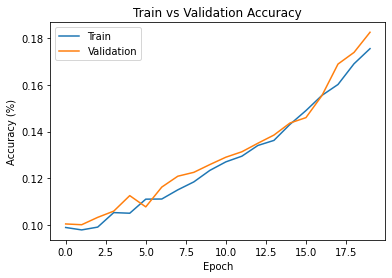

In [ ]:
train()

Follow the assignment handout for questions to be answered in this part of the assignment.

Hyperparameters are parameters that the user has specifically established to regulate the learning process of the model. 


Often, we are unaware of the hyperparameters' ideal values that would produce the best model results from the onset. Thus, we must tune the hyperparameters to attain the highest validation accuracy/lowest validation loss. This can be done in our case, via trial and error by testing different hyperparameters values and creating different instantiations of models. Without trying different hyperparameter values, we might be left with a model which isn't accurate and that doesn't offer much insight in terms of predictions when we move onto the testing data which is more practical. 

Q 2.5

The four hyperparameters that I have chosen to tune are: batch size, learning rate, number of output channels in convolution layer 1, and activation function.

With this in mind, two different hyperparameter settings are:

H1 = {16, 0.01, 24, sigmoid}

H2 = {24, 0.003, 16, tanh}

**M1 Model Class with H1 Hyperparameters**

In [ ]:
# H1 = {16, 0.01, 24, sigmoid}
# M1 model class with H1 hyperparameter selection
class M1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 24, 2), objax.functional.sigmoid])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(24, 32, 2), objax.functional.sigmoid])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M1()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.12 Validation Accuracy 13.22
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 14.37 Validation Accuracy 14.65
Epoch 0003  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 16.02 Validation Accuracy 15.78
Epoch 0004  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 17.67 Validation Accuracy 15.93
Epoch 0005  Training Loss 2.26 Validation Loss 2.24 Training Accuracy 18.43 Validation Accuracy 15.43
Epoch 0006  Training Loss 2.23 Validation Loss 2.21 Training Accuracy 18.78 Validation Accuracy 18.05
Epoch 0007  Training Loss 2.20 Validation Loss 2.18 Training Accuracy 19.59 Validation Accuracy 17.83
Epoch 0008  Training Loss 2.17 Validation Loss 2.15 Training Accuracy 20.09 Validation Accuracy 19.72
Epoch 0009  Training Loss 2.14 Validation Loss 2.13 Training Accuracy 20.52 Validation Accuracy 20.20
Epoch 0010  Training Loss 2.13 Validation Loss 2.12 Training Accuracy 20.99 Valida

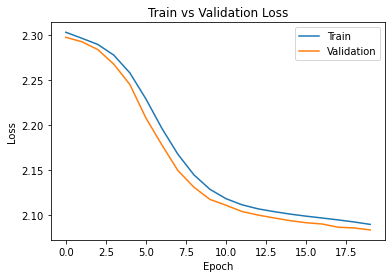

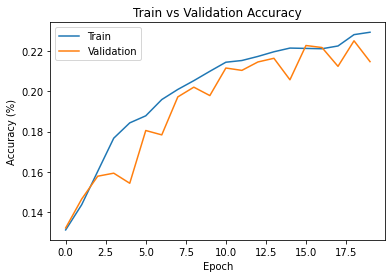

In [ ]:
train()

**M2 Model Class with H2 Hyperparameters**

In [ ]:
# H2 = {24, 0.003, 16, tanh}
# M2 model class with H1 hyperparameter selection
class M2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.tanh])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.tanh])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = M2()
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [ ]:
def train(EPOCHS = 20, BATCH = 24, LEARNING_RATE = 0.003):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.30 Validation Loss 2.27 Training Accuracy 12.28 Validation Accuracy 17.72
Epoch 0002  Training Loss 2.26 Validation Loss 2.23 Training Accuracy 18.68 Validation Accuracy 20.77
Epoch 0003  Training Loss 2.21 Validation Loss 2.18 Training Accuracy 21.57 Validation Accuracy 22.30
Epoch 0004  Training Loss 2.15 Validation Loss 2.12 Training Accuracy 22.61 Validation Accuracy 24.12
Epoch 0005  Training Loss 2.11 Validation Loss 2.08 Training Accuracy 23.60 Validation Accuracy 23.18
Epoch 0006  Training Loss 2.07 Validation Loss 2.06 Training Accuracy 24.39 Validation Accuracy 24.32
Epoch 0007  Training Loss 2.05 Validation Loss 2.04 Training Accuracy 24.74 Validation Accuracy 24.73
Epoch 0008  Training Loss 2.03 Validation Loss 2.02 Training Accuracy 25.19 Validation Accuracy 25.00
Epoch 0009  Training Loss 2.02 Validation Loss 2.01 Training Accuracy 25.62 Validation Accuracy 25.38
Epoch 0010  Training Loss 2.01 Validation Loss 2.00 Training Accuracy 25.85 Valida

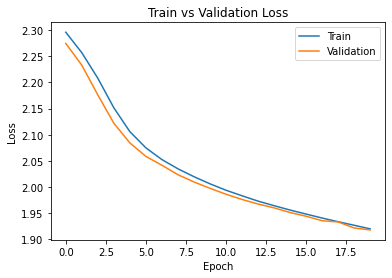

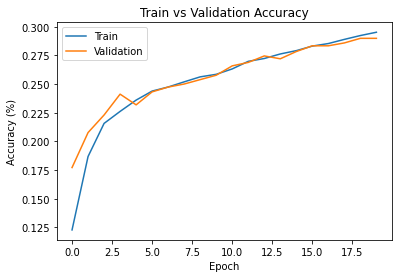

In [ ]:
train()

Report the best validation accuracy as well as the corresponding epoch for which this occurs for the Base Model and your two additional models:

Base Model: 18.27% at Epoch 20

M1: 22.50% at Epoch 19

M2: 28.98% at Epoch 20

The model I would select against test data is M2. M2 has the highest validation accuracy amongst the two other models, which is an indicator that its hyperparameters do the best job in attaining higher accuracy with unseen data. Thus, I expect M2 to perform the best with test data.

In [ ]:
mean_test_loss = float(loss_function(X_test, Y_test)) 
test_prediction = predict(X_test).argmax(1)
test_acc = ((np.array(test_prediction).flatten() == Y_test).sum())/X_test.shape[0]
print('Mean Test Loss: %.2f' % (mean_test_loss))
print('Test set accuracy: %.2f' % (test_acc*100))

Mean Test Loss: 2.34
Test set accuracy: 9.97


You have now completed Part 2 of the assignment. Good job!


##**Part 3. Trying Out a New Dataset**

See the handout for instructions.


In [3]:
# I chose to use the Fashion_MNIST dataset
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

X_train = np.expand_dims(X_train, 1)
X_train = X_train / 255.0
X_test = np.expand_dims(X_test, 1)
X_test = X_test / 255.0

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]

11490434/11490434 [==============================] - 0s 0us/step


For the base model, I will use a similar base model the Conv Network I built in Q1


In [4]:
class Fashion_MNIST(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = Fashion_MNIST(number_of_channels=1, number_of_classes = 10)
#You can examine the architecture of our CNN by calling model.vars()

In [ ]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

In [6]:
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] #PUT YOUR CODE HERE#
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 9.73 Validation Accuracy 9.99
Epoch 0002  Training Loss 2.30 Validation Loss 2.29 Training Accuracy 9.86 Validation Accuracy 10.26
Epoch 0003  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 10.18 Validation Accuracy 10.54
Epoch 0004  Training Loss 2.29 Validation Loss 2.28 Training Accuracy 10.99 Validation Accuracy 11.59
Epoch 0005  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 12.33 Validation Accuracy 13.27
Epoch 0006  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 13.74 Validation Accuracy 14.99
Epoch 0007  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 15.44 Validation Accuracy 16.30
Epoch 0008  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 16.59 Validation Accuracy 17.56
Epoch 0009  Training Loss 2.27 Validation Loss 2.27 Training Accuracy 17.74 Validation Accuracy 18.14
Epoch 0010  Training Loss 2.26 Validation Loss 2.26 Training Accuracy 18.47 Validatio

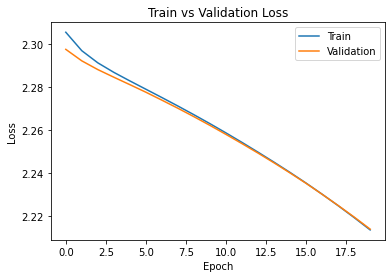

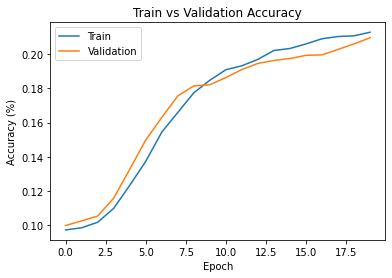

In [ ]:
train()

For my base model here are the hyperparameters that were used:

*   Batch Size = 32
*   Learning Rate = 9e-4
*   Convolutional kernel size = 2
*   Number of output channels respectively = 16, 32
*   Activation Function = ReLu
*   Number of convolutional layers: 2
*   Number of fully-connected layers, optimizer, etc.

I want to tune 3 of these hyperparameters in greater affect, namely batch size, learning rate, and the activation function. I will conduct tests and find the best model which gives me 5-10% better validation accuracy than my base model. Currently my base model achieves 21.50% validation accuracy as its highest at epoch 20.




Epoch 0001  Training Loss 2.37 Validation Loss 2.33 Training Accuracy 10.22 Validation Accuracy 9.86
Epoch 0002  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 10.22 Validation Accuracy 9.86
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 10.89 Validation Accuracy 10.66
Epoch 0004  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0005  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0006  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0007  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0008  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0009  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0010  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validati

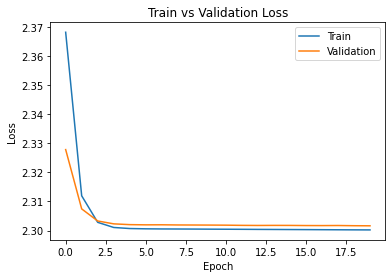

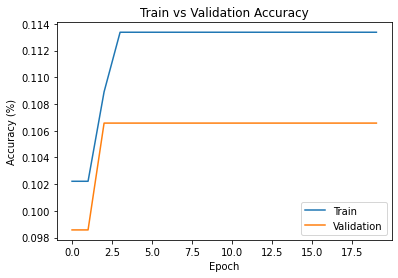

In [ ]:
# Model One:
# Tune Batch Size to be 64, but keep everthing else consistent as base model

model_one = Fashion_MNIST(number_of_channels=1, number_of_classes = 10)

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model_one(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model_one(x)), model_one.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model_one.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model_one.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())
train(EPOCHS = 20, BATCH = 64, LEARNING_RATE = 9e-4)

Epoch 0001  Training Loss 2.34 Validation Loss 2.30 Training Accuracy 9.89 Validation Accuracy 10.66
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0004  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0005  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0006  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0007  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0008  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0009  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validation Accuracy 10.66
Epoch 0010  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.34 Validat

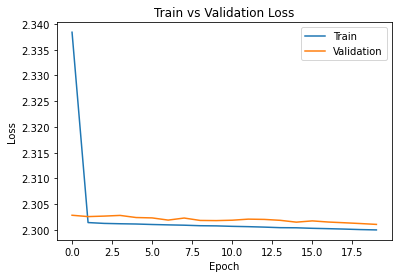

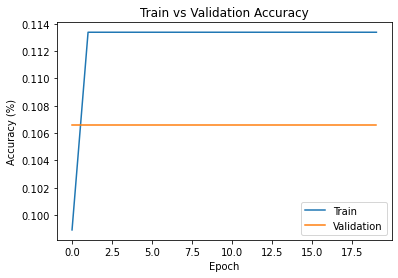

In [ ]:
# Model Two:
# Tune Batch Size to be 16, but keep everthing else consistent as base model

model_two = Fashion_MNIST(number_of_channels=1, number_of_classes = 10)

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model_two(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model_two(x)), model_two.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model_two.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model_two.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())
train(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 9e-4)

From the three batch size tests I tried, when I trained the second model (with batch size of 16), I achieved the highest validation accuracy (26.6% at epoch 18). The base model gave a validation accuracy of 21.5% at its highest and the first model with batch size of 64 gave a validation accuracy of 19.53% at its highest. Therefore, I will proceed with my other hyperparameter tuning with batch size as 16.

Epoch 0001  Training Loss 2.25 Validation Loss 2.17 Training Accuracy 18.39 Validation Accuracy 21.84
Epoch 0002  Training Loss 2.05 Validation Loss 1.98 Training Accuracy 25.87 Validation Accuracy 25.54
Epoch 0003  Training Loss 1.96 Validation Loss 1.95 Training Accuracy 29.32 Validation Accuracy 26.27
Epoch 0004  Training Loss 1.92 Validation Loss 1.91 Training Accuracy 31.54 Validation Accuracy 29.27
Epoch 0005  Training Loss 1.87 Validation Loss 1.84 Training Accuracy 34.94 Validation Accuracy 33.23
Epoch 0006  Training Loss 1.77 Validation Loss 1.72 Training Accuracy 39.84 Validation Accuracy 36.27
Epoch 0007  Training Loss 1.64 Validation Loss 1.58 Training Accuracy 45.10 Validation Accuracy 39.81
Epoch 0008  Training Loss 1.52 Validation Loss 1.47 Training Accuracy 49.02 Validation Accuracy 45.49
Epoch 0009  Training Loss 1.44 Validation Loss 1.45 Training Accuracy 52.16 Validation Accuracy 43.94
Epoch 0010  Training Loss 1.38 Validation Loss 1.34 Training Accuracy 55.12 Valida

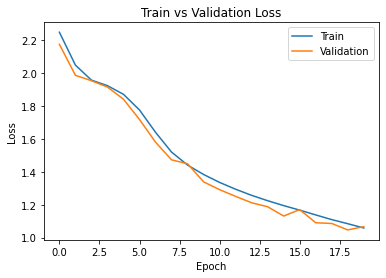

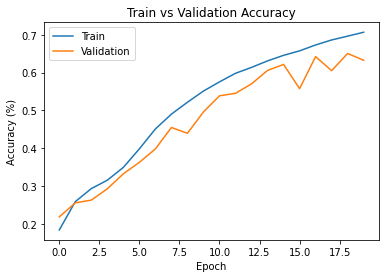

In [12]:
# Model Three:
# Batch Size = 16, Learning Rate = 0.01, but keep everthing else consistent as base model

model_three = Fashion_MNIST(number_of_channels=1, number_of_classes = 10)

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model_three(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model_three(x)), model_three.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model_three.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model_three.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())
train(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 0.01)

Epoch 0001  Training Loss 2.27 Validation Loss 2.24 Training Accuracy 16.58 Validation Accuracy 20.17
Epoch 0002  Training Loss 2.19 Validation Loss 2.15 Training Accuracy 22.47 Validation Accuracy 21.67
Epoch 0003  Training Loss 2.07 Validation Loss 2.02 Training Accuracy 25.79 Validation Accuracy 24.56
Epoch 0004  Training Loss 1.98 Validation Loss 1.97 Training Accuracy 27.93 Validation Accuracy 26.60
Epoch 0005  Training Loss 1.95 Validation Loss 1.95 Training Accuracy 29.34 Validation Accuracy 26.59
Epoch 0006  Training Loss 1.92 Validation Loss 1.93 Training Accuracy 30.75 Validation Accuracy 29.86
Epoch 0007  Training Loss 1.89 Validation Loss 1.90 Training Accuracy 32.44 Validation Accuracy 29.77
Epoch 0008  Training Loss 1.86 Validation Loss 1.85 Training Accuracy 34.14 Validation Accuracy 32.90
Epoch 0009  Training Loss 1.81 Validation Loss 1.80 Training Accuracy 36.26 Validation Accuracy 32.61
Epoch 0010  Training Loss 1.75 Validation Loss 1.73 Training Accuracy 38.81 Valida

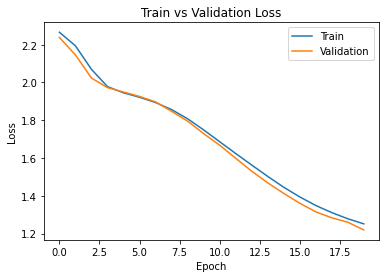

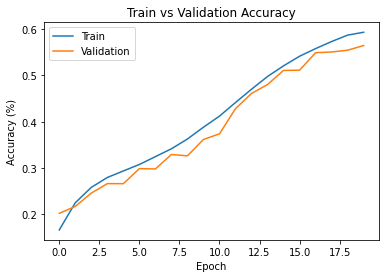

In [ ]:
# Model Four:
# Batch Size = 16, Learning Rate = 0.005, but keep everthing else consistent as base model

model_four = Fashion_MNIST(number_of_channels=1, number_of_classes = 10)

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model_four(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model_four(x)), model_four.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model_four.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model_four.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())
train(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 0.005)

My tunings with learning rate vastly improved my validation accuracy. With the previous establishment that batch size should be 16, I tried using a learning rate of 0.01 and 0.005. The learning rate of 0.01 gave a validation accuracy of 65.64% in epoch 18 and the learning rate of 0.005 gave a validation accuracy of 56.49% in epoch 20. These are significantly better than my base model which had a learning rate of 9e-4. I will therefore proceed with a learning rate of 0.01.

Epoch 0001  Training Loss 2.21 Validation Loss 2.11 Training Accuracy 19.89 Validation Accuracy 21.87
Epoch 0002  Training Loss 2.03 Validation Loss 2.00 Training Accuracy 24.99 Validation Accuracy 24.83
Epoch 0003  Training Loss 1.96 Validation Loss 1.95 Training Accuracy 27.49 Validation Accuracy 27.09
Epoch 0004  Training Loss 1.93 Validation Loss 1.93 Training Accuracy 28.65 Validation Accuracy 27.90
Epoch 0005  Training Loss 1.91 Validation Loss 1.92 Training Accuracy 29.44 Validation Accuracy 27.24
Epoch 0006  Training Loss 1.90 Validation Loss 1.90 Training Accuracy 29.76 Validation Accuracy 28.07
Epoch 0007  Training Loss 1.89 Validation Loss 1.91 Training Accuracy 30.31 Validation Accuracy 27.67
Epoch 0008  Training Loss 1.88 Validation Loss 1.89 Training Accuracy 30.87 Validation Accuracy 28.89
Epoch 0009  Training Loss 1.88 Validation Loss 1.90 Training Accuracy 31.44 Validation Accuracy 28.83
Epoch 0010  Training Loss 1.87 Validation Loss 1.87 Training Accuracy 31.90 Valida

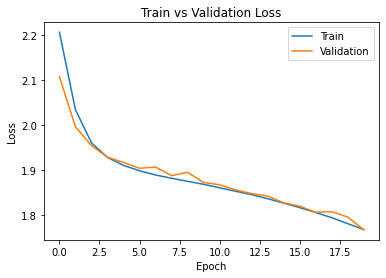

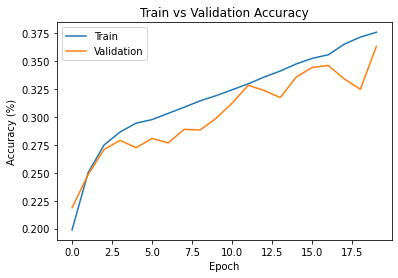

In [ ]:
# Model Five:
# Batch Size = 16, Learning Rate = 0.01, Activation Function = tanh, but keep everthing else consistent as base model

class Fashion_MNIST(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.tanh])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.tanh])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model_five = Fashion_MNIST(number_of_channels=1, number_of_classes = 10)
#You can examine the architecture of our CNN by calling model.vars()
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model_five(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()
#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model_five(x)), model_five.vars()) 
#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model_five.vars())
#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model_five.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())
train(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 0.01)

Epoch 0001  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.77 Validation Accuracy 10.66
Epoch 0002  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.14 Validation Accuracy 10.66
Epoch 0003  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.31 Validation Accuracy 12.29
Epoch 0004  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.35 Validation Accuracy 10.49
Epoch 0005  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.38 Validation Accuracy 17.26
Epoch 0006  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 13.50 Validation Accuracy 11.44
Epoch 0007  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 14.73 Validation Accuracy 16.44
Epoch 0008  Training Loss 2.29 Validation Loss 2.29 Training Accuracy 15.47 Validation Accuracy 16.51
Epoch 0009  Training Loss 2.28 Validation Loss 2.28 Training Accuracy 16.88 Validation Accuracy 14.59
Epoch 0010  Training Loss 2.28 Validation Loss 2.27 Training Accuracy 17.92 Valida

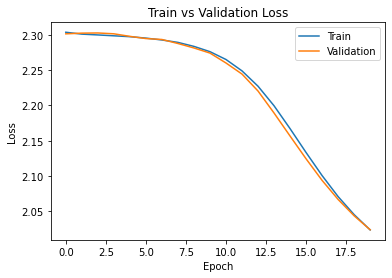

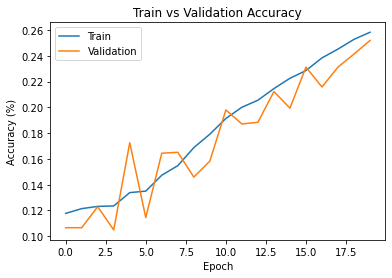

In [ ]:
# Model Six:
# Batch Size = 16, Learning Rate = 0.01, Activation Function = sigmoid, but keep everthing else consistent as base model

class Fashion_MNIST(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.sigmoid])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.sigmoid])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model_six = Fashion_MNIST(number_of_channels=1, number_of_classes = 10)
#You can examine the architecture of our CNN by calling model.vars()

#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model_six(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model_six(x)), model_six.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model_six.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model_six.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())
train(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 0.01)

After looking at my results for the sigmoid and tanh activation functions, they are significantly worse than my ReLu activation function with batch size of 16 and learning rate of 0.01 established in model 3. Therefore, for the hyperparameter tuning I have done, the best validation accuracy I have come up with is 65.64% which is better than the 21.5% validation accuracy I had for the base model. There are many ways to improve the 65.64% validation accuracy even further; for example, we could experiment further with batch size and learning rate, we could add more convolutional layers and fully connected layers, we could change the number of output channels, and we could change the kernel size. However, due to Colab's limited GPU usage and the fact that I only needed to get a 5-10% validation accuracy than my base model, I feel that the new hyperparameters I have come up with do a good job.

Therefore, my final model chosen was model 3. The hyperparameter tunings I made from the base model were:

*   Batch Size = 16
*   Learning Rate = 0.01


By running model 3 the most recent, we can write the mean test loss and test prediction and accuracy lines of code to attain the test set accuracy which in this case is 63.41%.

In [13]:
mean_test_loss = float(loss_function(X_test, Y_test)) 
test_prediction = predict(X_test).argmax(1)
test_acc = ((np.array(test_prediction).flatten() == Y_test).sum())/X_test.shape[0]
print('Mean Test Loss: %.2f' % (mean_test_loss))
print('Test set accuracy: %.2f' % (test_acc*100))

Mean Test Loss: 1.08
Test set accuracy: 63.41


##**Problem 4. Open-Ended Exploration**

See the handout for instructions.

From Question 3.3, I tried several hyperparameter tuning operations including changing the batch size from 32 to 64 to 16, changing the learning rate from 9e-4 to 0.01 to 0.005, and changing different activation functions such as ReLu, sigmoid and tanh. My highest validation accuracy, 65.64%, was achieved by using ReLu activation function, a batch size of 16 and a learning rate of 0.01. This was a massive increase from the base model's validation accuracy of 21.50%. However, I still identify several other hyperparameters which I haven't had a chance to tune. The question I have selected to choose for Question 4 is: **Additional hyperparameter tuning** and I will be using my 65.64% as my new base model for further tuning. My goal is to achieve a model which attains 5-10% higher validation accuracy than my base model. Some hyperparameters that I plan to tune individually are: 
*   Kernel Size of each layer
*   Number of output channels

Epoch 0001  Training Loss 2.23 Validation Loss 2.14 Training Accuracy 18.13 Validation Accuracy 22.24
Epoch 0002  Training Loss 1.98 Validation Loss 1.85 Training Accuracy 32.00 Validation Accuracy 35.47
Epoch 0003  Training Loss 1.69 Validation Loss 1.52 Training Accuracy 44.80 Validation Accuracy 46.57
Epoch 0004  Training Loss 1.37 Validation Loss 1.22 Training Accuracy 60.19 Validation Accuracy 60.56
Epoch 0005  Training Loss 1.14 Validation Loss 1.06 Training Accuracy 70.39 Validation Accuracy 63.96
Epoch 0006  Training Loss 0.97 Validation Loss 0.87 Training Accuracy 76.21 Validation Accuracy 74.61
Epoch 0007  Training Loss 0.83 Validation Loss 0.81 Training Accuracy 80.72 Validation Accuracy 74.77
Epoch 0008  Training Loss 0.72 Validation Loss 0.68 Training Accuracy 84.02 Validation Accuracy 78.79
Epoch 0009  Training Loss 0.64 Validation Loss 0.59 Training Accuracy 86.41 Validation Accuracy 82.14
Epoch 0010  Training Loss 0.58 Validation Loss 0.60 Training Accuracy 88.21 Valida

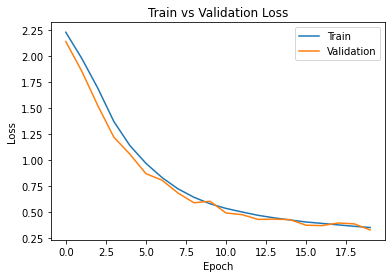

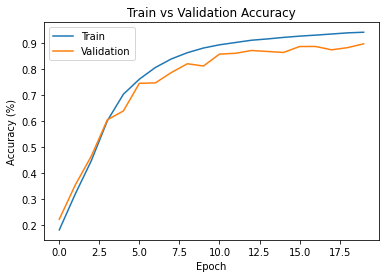

In [14]:
# Model Seven:
# Kernel Size = 3 for each conv layer, but keep everthing else consistent as base model

class Fashion_MNIST(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 3), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 3), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model_seven = Fashion_MNIST(number_of_channels=1, number_of_classes = 10)
#You can examine the architecture of our CNN by calling model.vars()
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model_seven(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()
#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model_seven(x)), model_seven.vars()) 
#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model_seven.vars())
#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model_seven.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())
train(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 0.01)

Epoch 0001  Training Loss 2.15 Validation Loss 1.93 Training Accuracy 24.22 Validation Accuracy 29.81
Epoch 0002  Training Loss 1.71 Validation Loss 1.50 Training Accuracy 44.08 Validation Accuracy 49.96
Epoch 0003  Training Loss 1.24 Validation Loss 0.98 Training Accuracy 68.01 Validation Accuracy 70.17
Epoch 0004  Training Loss 0.79 Validation Loss 0.62 Training Accuracy 83.92 Validation Accuracy 82.89
Epoch 0005  Training Loss 0.58 Validation Loss 0.49 Training Accuracy 89.64 Validation Accuracy 85.53
Epoch 0006  Training Loss 0.47 Validation Loss 0.40 Training Accuracy 92.29 Validation Accuracy 88.29
Epoch 0007  Training Loss 0.40 Validation Loss 0.38 Training Accuracy 93.83 Validation Accuracy 88.26
Epoch 0008  Training Loss 0.35 Validation Loss 0.30 Training Accuracy 94.92 Validation Accuracy 91.34
Epoch 0009  Training Loss 0.31 Validation Loss 0.28 Training Accuracy 95.59 Validation Accuracy 91.94
Epoch 0010  Training Loss 0.28 Validation Loss 0.27 Training Accuracy 96.04 Valida

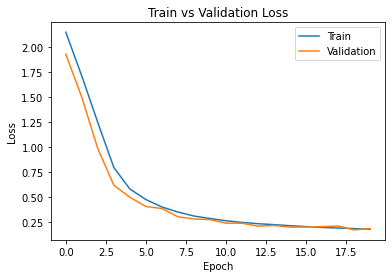

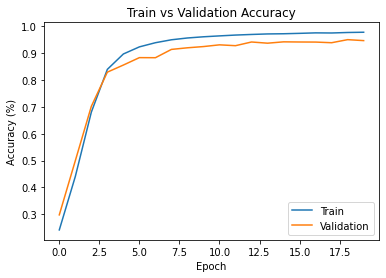

In [16]:
# Model Eight:
# Kernel Size = 4 for each conv layer, but keep everthing else consistent as base model

class Fashion_MNIST(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 4), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 4), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model_eight = Fashion_MNIST(number_of_channels=1, number_of_classes = 10)
#You can examine the architecture of our CNN by calling model.vars()
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model_eight(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()
#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model_eight(x)), model_eight.vars()) 
#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model_eight.vars())
#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model_eight.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())
train(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 0.01)

Epoch 0001  Training Loss 2.22 Validation Loss 2.08 Training Accuracy 20.81 Validation Accuracy 25.53
Epoch 0002  Training Loss 1.87 Validation Loss 1.66 Training Accuracy 38.15 Validation Accuracy 46.87
Epoch 0003  Training Loss 1.35 Validation Loss 1.05 Training Accuracy 63.83 Validation Accuracy 69.37
Epoch 0004  Training Loss 0.84 Validation Loss 0.67 Training Accuracy 82.84 Validation Accuracy 81.20
Epoch 0005  Training Loss 0.59 Validation Loss 0.52 Training Accuracy 89.27 Validation Accuracy 85.06
Epoch 0006  Training Loss 0.48 Validation Loss 0.44 Training Accuracy 91.88 Validation Accuracy 86.84
Epoch 0007  Training Loss 0.41 Validation Loss 0.39 Training Accuracy 93.29 Validation Accuracy 88.01
Epoch 0008  Training Loss 0.37 Validation Loss 0.31 Training Accuracy 94.32 Validation Accuracy 91.13
Epoch 0009  Training Loss 0.34 Validation Loss 0.37 Training Accuracy 94.93 Validation Accuracy 88.44
Epoch 0010  Training Loss 0.31 Validation Loss 0.35 Training Accuracy 95.40 Valida

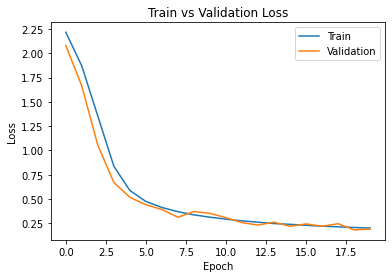

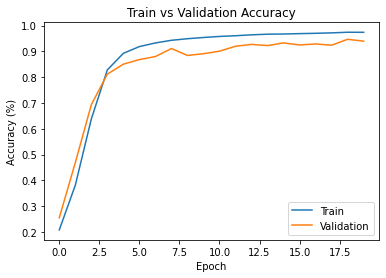

In [18]:
# Model Nine:
# Kernel Size = 4 for each conv layer 
# Output channel of first conv layer = 8, Input channel of second conv layer = 8
# but keep everthing else consistent as base model

class Fashion_MNIST(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 8, 4), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(8, 32, 4), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model_nine = Fashion_MNIST(number_of_channels=1, number_of_classes = 10)
#You can examine the architecture of our CNN by calling model.vars()
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model_nine(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()
#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model_nine(x)), model_nine.vars()) 
#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model_nine.vars())
#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model_nine.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())
train(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 0.01)

Epoch 0001  Training Loss 2.15 Validation Loss 1.93 Training Accuracy 24.04 Validation Accuracy 30.77
Epoch 0002  Training Loss 1.74 Validation Loss 1.47 Training Accuracy 45.88 Validation Accuracy 58.03
Epoch 0003  Training Loss 1.17 Validation Loss 0.89 Training Accuracy 72.04 Validation Accuracy 75.77
Epoch 0004  Training Loss 0.74 Validation Loss 0.63 Training Accuracy 85.37 Validation Accuracy 80.23
Epoch 0005  Training Loss 0.56 Validation Loss 0.46 Training Accuracy 90.14 Validation Accuracy 86.26
Epoch 0006  Training Loss 0.46 Validation Loss 0.39 Training Accuracy 92.45 Validation Accuracy 88.27
Epoch 0007  Training Loss 0.40 Validation Loss 0.33 Training Accuracy 93.74 Validation Accuracy 90.64
Epoch 0008  Training Loss 0.36 Validation Loss 0.31 Training Accuracy 94.68 Validation Accuracy 90.77
Epoch 0009  Training Loss 0.33 Validation Loss 0.30 Training Accuracy 95.14 Validation Accuracy 90.90
Epoch 0010  Training Loss 0.31 Validation Loss 0.29 Training Accuracy 95.62 Valida

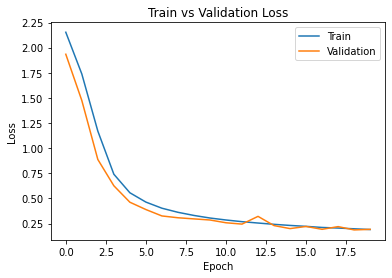

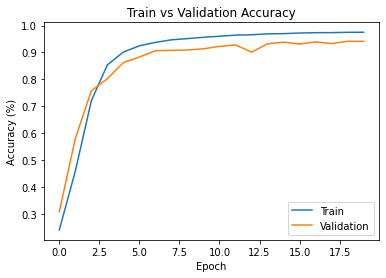

In [19]:
# Model Ten:
# Kernel Size = 4 for each conv layer 
# Output channel of first conv layer = 24, Input channel of second conv layer = 24
# but keep everthing else consistent as base model

class Fashion_MNIST(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 24, 4), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(24, 32, 4), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = self.conv_1(x)
    x = objax.functional.max_pool_2d(x, 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model_nine = Fashion_MNIST(number_of_channels=1, number_of_classes = 10)
#You can examine the architecture of our CNN by calling model.vars()
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model_nine(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()
#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model_nine(x)), model_nine.vars()) 
#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model_nine.vars())
#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model_nine.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure
    for grad, params in zip(gradient, tv.vars()):
      ####################
      #PUT YOUR CODE HERE#
      ####################
      params.assign(params.value - lr * grad)                      
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())
train(EPOCHS = 20, BATCH = 16, LEARNING_RATE = 0.01)

I have tried four new models for the additional hyperparameter testing. These involved tuning the output channel for the first convolution layer, the input channel for the second convolution layer and the kernel size for both the convolution layers. Initially, the base model was made with kernel size of 2 for each convolution layer. Upon increasing this kernel size to 3, I attained a validation accuracy of 89.83%. Upon further increasing this kernel size to 4, I attained a validation accuracy of 94.97%. I decided to proceed with the kernel size of 4 and then tune the output channel for the first convolution layer and the input channel for the second convolution layer. I first lowered the number of channels from 16 to 8 for each layer and attained a validation accuracy of 94.70%. I then tried increased the number of channels from 16 to 24 and attained a validation accuracy of 94.14%. Ultimately, both of these channel adjustments failed to render a higher validation accuracy than the one I achieved for the original 16 channels. Thus, I concluded that the best hyperparameter selection was:  

*   Batch size = 16
*   Learning rate = 0.01
*   Number of output channels for first conv layer and input for second conv layer = 16
*   Kernel size = 4

By running the model which rendered the highest validation accuracy, Model 8, most recently, we can find the mean test loss and the test accuracy. The test accuracy generated by this model is 94.41%.

In [17]:
mean_test_loss = float(loss_function(X_test, Y_test)) 
test_prediction = predict(X_test).argmax(1)
test_acc = ((np.array(test_prediction).flatten() == Y_test).sum())/X_test.shape[0]
print('Mean Test Loss: %.2f' % (mean_test_loss))
print('Test set accuracy: %.2f' % (test_acc*100))

Mean Test Loss: 0.18
Test set accuracy: 94.41
